Standalone web application?

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
#load data
df = pd.read_csv('startup data.csv')

In [3]:
df.info()
# Note: the dataset contains a total of 49 columns, 923 rows, and some columns have missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [4]:
#replace nulls
df = df.replace('NaN', np.nan) 

#row 124 and 832 are repeats of the same data point
df.iloc[124] == df.iloc[832]
df = df.drop(832)

In [5]:
#check for unique id columns that can be ignored
print(df['Unnamed: 0'].value_counts().shape == df['Unnamed: 0'].shape)
print(df['id'].value_counts().shape == df['id'].shape)
print(df['name'].value_counts().shape == df['name'].shape)
print(df['object_id'].value_counts().shape == df['object_id'].shape)


True
True
True
True


In [6]:
df.drop(["Unnamed: 6"],axis=1, inplace=True)
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.drop(["id"], axis=1, inplace=True)
df.drop(["closed_at"], axis=1, inplace=True)

df.head()

,state_code,latitude,longitude,zip_code,city,name,labels,founded_at,first_funding_at,last_funding_at,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,42.358880,-71.056820,92101,San Diego,Bandsintown,1,1/1/2007,4/1/2009,1/1/2010,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,CA,37.238916,-121.973718,95032,Los Gatos,TriCipher,1,1/1/2000,2/14/2005,12/28/2009,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,CA,32.901049,-117.192656,92121,San Diego,Plixi,1,3/18/2009,3/30/2010,3/30/2010,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,CA,37.320309,-122.050040,95014,Cupertino,Solidcore Systems,1,1/1/2002,2/17/2005,4/25/2007,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,CA,37.779281,-122.419236,94105,San Francisco,Inhale Digital,0,8/1/2010,8/1/2010,4/1/2012,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


## EDA

In [7]:
#all remaining features split between categorical/continuous/dates to be transformed to continuous
#categorical features split further between ordinal scaler and one hot encoder

cat_ftrs = ['state_code', 'zip_code', 'city','labels', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones']

ss_ftrs = ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 
            'funding_rounds', 'avg_participants', 'funding_total_usd',]

dates = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']

In order to see the relationships between the columns age_first_funding_year, age_last_funding_year, age_first_milestone_year, age_last_milestone_year, we create scatterplots.

In [8]:
df.drop(["state_code.1"], axis=1, inplace=True)


In [9]:

df=pd.get_dummies(df, columns=["status"], drop_first=True)


In [10]:

df.founded_at=pd.to_datetime(df.founded_at)
df.first_funding_at=pd.to_datetime(df.first_funding_at)
df.last_funding_at=pd.to_datetime(df.last_funding_at)

df.head(3)

,state_code,latitude,longitude,zip_code,city,name,labels,founded_at,first_funding_at,last_funding_at,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status_closed
0,CA,42.358880,-71.056820,92101,San Diego,Bandsintown,1,2007-01-01,2009-04-01,2010-01-01,...,c:6669,0,1,0,0,0,0,1.00,0,0
1,CA,37.238916,-121.973718,95032,Los Gatos,TriCipher,1,2000-01-01,2005-02-14,2009-12-28,...,c:16283,1,0,0,1,1,1,4.75,1,0
2,CA,32.901049,-117.192656,92121,San Diego,Plixi,1,2009-03-18,2010-03-30,2010-03-30,...,c:65620,0,0,1,0,0,0,4.00,1,0


C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, "Difference 'Founded' and 'First Funding'")

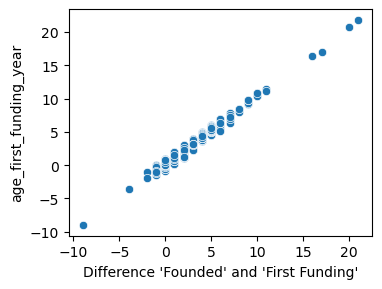

In [11]:
plt.figure(figsize=(18,3),dpi=100)


plt.subplot(1,4,1)
sns.scatterplot((df["first_funding_at"].dt.year - df["founded_at"].dt.year), df["age_first_funding_year"])
plt.xlabel("Difference 'Founded' and 'First Funding'")
        

C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

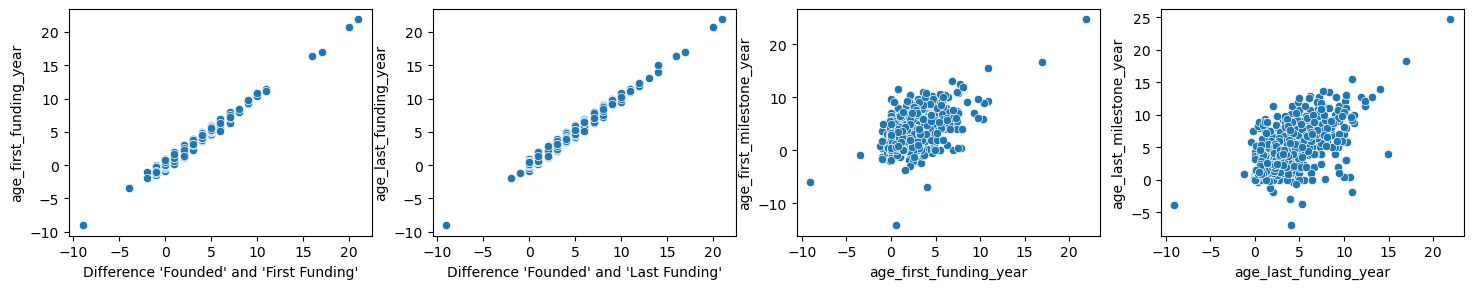

In [12]:
plt.figure(figsize=(18,3),dpi=100)

plt.subplot(1,4,1)
sns.scatterplot((df["first_funding_at"].dt.year - df["founded_at"].dt.year), df["age_first_funding_year"])
plt.xlabel("Difference 'Founded' and 'First Funding'")

plt.subplot(1,4,2)
sns.scatterplot((df["last_funding_at"].dt.year- df["founded_at"].dt.year), df["age_last_funding_year"])
plt.xlabel("Difference 'Founded' and 'Last Funding'");

plt.subplot(1,4,3)
sns.scatterplot(df["age_first_funding_year"], df["age_first_milestone_year"])

plt.subplot(1,4,4)
sns.scatterplot(df["age_last_funding_year"], df["age_last_milestone_year"]);


Note some of these values are negative, because we are simply getting the difference between "last_funding_at" and "founded_at" is related "age_last_funding_year". 
So we will get the absolute value of columns that include negative values.

In [13]:
df["age_first_funding_year"]=np.abs(df["age_first_funding_year"])
df["age_last_funding_year"]=np.abs(df["age_last_funding_year"])
df["age_first_milestone_year"]=np.abs(df["age_first_milestone_year"])
df["age_last_milestone_year"]=np.abs(df["age_last_milestone_year"])

age=["age_first_funding_year","age_last_funding_year","age_first_milestone_year","age_last_milestone_year"]

Now we can get a more accurate visualization of the relationships.

C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

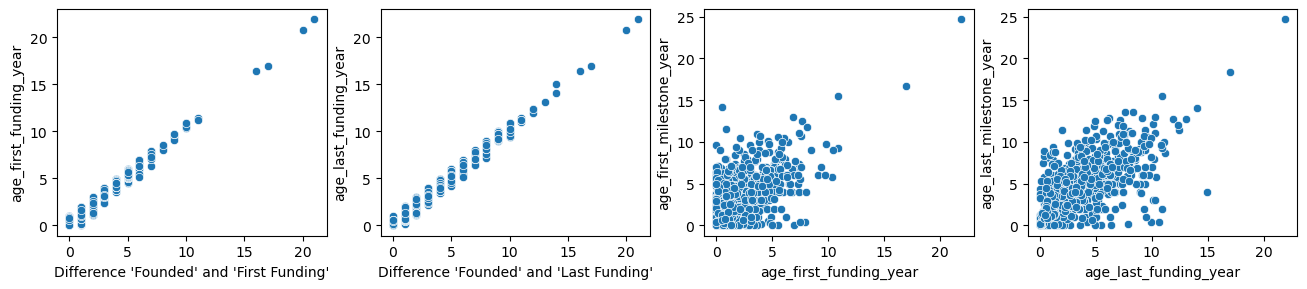

In [14]:
plt.figure(figsize=(16,3),dpi=100)

plt.subplot(1,4,1)
sns.scatterplot(np.abs(df["first_funding_at"].dt.year - df["founded_at"].dt.year), df["age_first_funding_year"])
plt.xlabel("Difference 'Founded' and 'First Funding'")

plt.subplot(1,4,2)
sns.scatterplot(np.abs(df["last_funding_at"].dt.year- df["founded_at"].dt.year), df["age_last_funding_year"])
plt.xlabel("Difference 'Founded' and 'Last Funding'");

plt.subplot(1,4,3)
sns.scatterplot(df["age_first_funding_year"], df["age_first_milestone_year"])

plt.subplot(1,4,4)
sns.scatterplot(df["age_last_funding_year"], df["age_last_milestone_year"]);

In [15]:
df.describe()


,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status_closed
count,922.000000,922.000000,922.000000,922.000000,922.000000,770.000000,770.000000,922.000000,922.000000,9.220000e+02,...,922.000000,922.000000,922.000000,922.000000,922.00000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,38.518566,-103.519249,0.646421,2.305953,3.962764,3.228152,4.818968,7.703905,2.309111,2.541017e+07,...,0.322126,0.325380,0.254881,0.507592,0.39154,0.232104,0.099783,2.839225,0.809111,0.353579
std,3.743372,22.398102,0.478340,2.448321,2.926818,2.790925,3.117834,7.266762,1.390562,1.897371e+08,...,0.467545,0.468771,0.436031,0.500214,0.48836,0.422404,0.299873,1.875518,0.393215,0.478340
min,25.752358,-122.756956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,37.388869,-122.199823,0.000000,0.589725,1.731475,1.008875,2.473300,3.000000,1.000000,2.712500e+06,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.500000,1.000000,0.000000
50%,37.779281,-118.365504,1.000000,1.475350,3.537000,2.642500,4.495900,5.000000,2.000000,1.000000e+07,...,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,2.500000,1.000000,0.000000
75%,40.730646,-77.213612,1.000000,3.584925,5.561600,4.760250,6.755500,10.000000,3.000000,2.465264e+07,...,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,3.800000,1.000000,1.000000
max,59.335232,18.057121,1.000000,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,5.700000e+09,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,16.000000,1.000000,1.000000


count    922.000000
mean      38.518566
std        3.743372
min       25.752358
25%       37.388869
50%       37.779281
75%       40.730646
max       59.335232
Name: latitude, dtype: float64


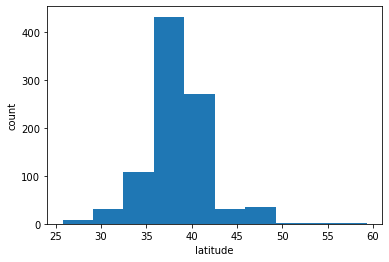

count    922.000000
mean    -103.519249
std       22.398102
min     -122.756956
25%     -122.199823
50%     -118.365504
75%      -77.213612
max       18.057121
Name: longitude, dtype: float64


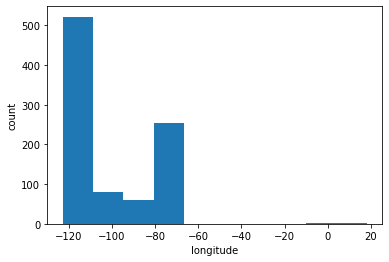

count    922.000000
mean       2.305953
std        2.448321
min        0.000000
25%        0.589725
50%        1.475350
75%        3.584925
max       21.895900
Name: age_first_funding_year, dtype: float64


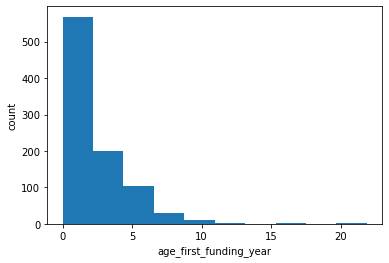

count    922.000000
mean       3.962764
std        2.926818
min        0.000000
25%        1.731475
50%        3.537000
75%        5.561600
max       21.895900
Name: age_last_funding_year, dtype: float64


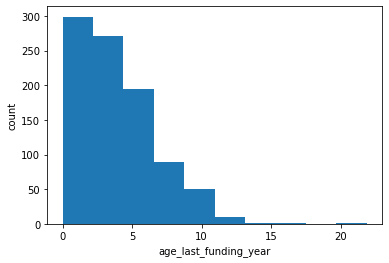

count    770.000000
mean       3.228152
std        2.790925
min        0.000000
25%        1.008875
50%        2.642500
75%        4.760250
max       24.684900
Name: age_first_milestone_year, dtype: float64


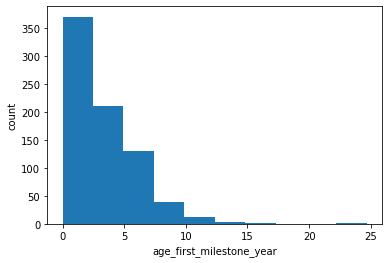

count    770.000000
mean       4.818968
std        3.117834
min        0.000000
25%        2.473300
50%        4.495900
75%        6.755500
max       24.684900
Name: age_last_milestone_year, dtype: float64


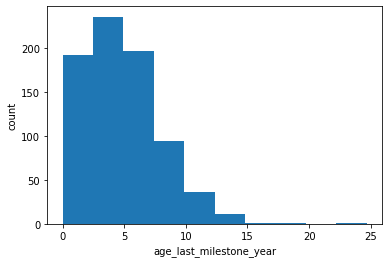

count    922.000000
mean       7.703905
std        7.266762
min        0.000000
25%        3.000000
50%        5.000000
75%       10.000000
max       63.000000
Name: relationships, dtype: float64


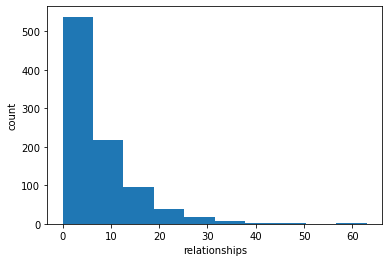

count    922.000000
mean       2.309111
std        1.390562
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: funding_rounds, dtype: float64


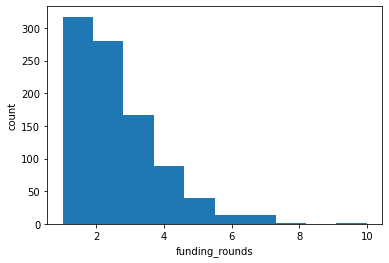

count    9.220000e+02
mean     2.541017e+07
std      1.897371e+08
min      1.100000e+04
25%      2.712500e+06
50%      1.000000e+07
75%      2.465264e+07
max      5.700000e+09
Name: funding_total_usd, dtype: float64


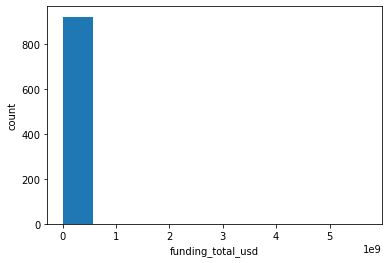

count    922.000000
mean       2.839225
std        1.875518
min        1.000000
25%        1.500000
50%        2.500000
75%        3.800000
max       16.000000
Name: avg_participants, dtype: float64


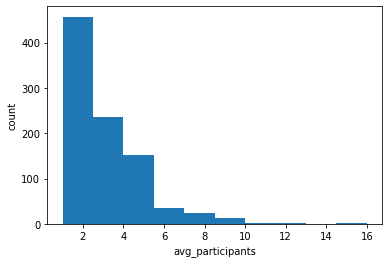

In [16]:
#histograms/bar charts of all features
columns = df.columns
for col in columns:
    if col in ss_ftrs:
        print(df[col].describe())
        df[col].plot.hist()
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()

In [17]:
#bar plots

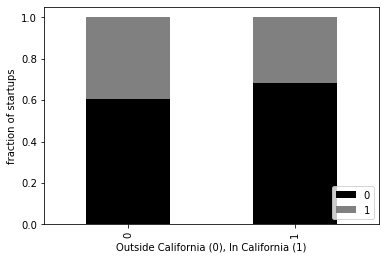

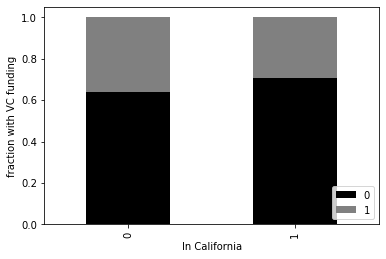

In [18]:
#comparing how well california startups did relative to the rest of the country
count_matrix = df.groupby(['is_CA', 'status_closed']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('Outside California (0), In California (1)')
plt.ylabel('fraction of startups')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['is_CA', 'has_VC']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('In California')
plt.ylabel('fraction with VC funding')
plt.legend(loc=4)
plt.show()

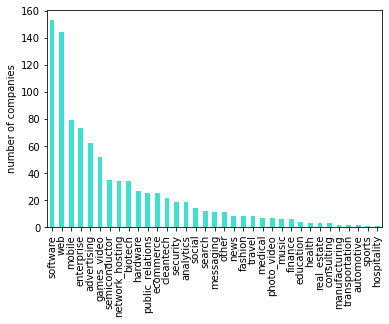

In [19]:
#histogram of the industries
df['category_code'].value_counts().plot.bar(color = 'turquoise')
plt.ylabel('number of companies')
plt.show()

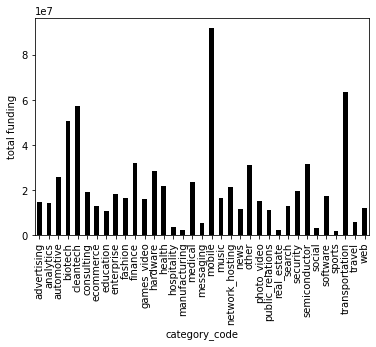

In [20]:
#plot showing industry type against total funding amount in usd
df.groupby('category_code', as_index=True)['funding_total_usd'].mean().plot.bar(color = 'k')
plt.ylabel('total funding')
plt.show()

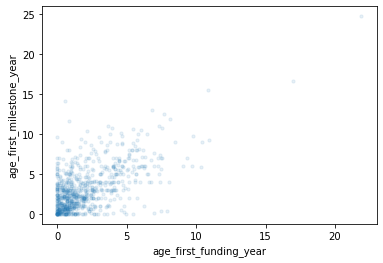

In [21]:
#comparing age of first funding year and age at first milestone shows a high concentration near (0,0)
#this is likely due to many companies who do not recieve any funding
#it is interesting to note the few outliers that were funded much later in their lives
df.plot.scatter('age_first_funding_year', 'age_first_milestone_year', s=10, alpha=.1)
plt.show()

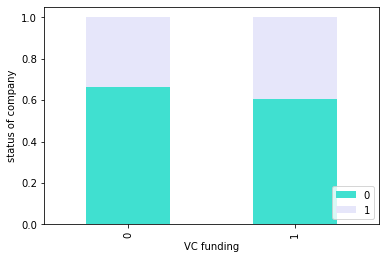

In [22]:
#funding vs status
count_matrix = df.groupby(['has_VC', 'status_closed']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['turquoise', 'lavender'])
plt.ylabel('status of company')
plt.xlabel('VC funding')
plt.legend(loc=4)
plt.show()

In [23]:
df.groupby(['has_VC', 'status_closed']).size().unstack()

status_closed,0,1
has_VC,,
0,414,208
1,182,118


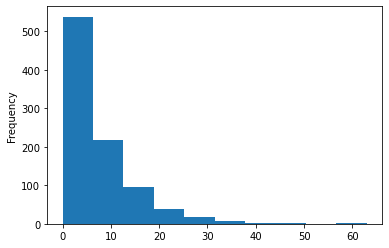

In [24]:
df['relationships'].plot.hist()


# df['category_code'].value_counts().plot.bar(color = 'turquoise')
# plt.ylabel('number of companies')
# plt.show()

## Split Data

In [25]:
#set X and y matrices
y = df['status_closed']
X = df.loc[:, df.columns != 'status_closed']

In [26]:
#data split
random_state = 7

#separate out training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)

#split out validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X,y,train_size = 0.5,random_state=random_state)

## Missing Data

In [33]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
age_first_milestone_year    0.164859
age_last_milestone_year     0.164859
dtype: float64
data types of the features with missing values:
age_first_milestone_year    float64
age_last_milestone_year     float64
dtype: object
fraction of points with missing values: 0.1648590021691974


In [34]:
#continuous missing values - multivariate imputation
print(df[['age_first_milestone_year','age_last_milestone_year']].head())

imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=10), random_state=1000)
X_impute = imputer.fit_transform(df[['age_first_milestone_year','age_last_milestone_year']])
df_imp = pd.DataFrame(data=X_impute, columns = df[['age_first_milestone_year','age_last_milestone_year']])

#print(df_train_imp[['LotFrontage','MasVnrArea','GarageYrBlt']].head())

#df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
#df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

   age_first_milestone_year  age_last_milestone_year
0                    4.6685                   6.7041
1                    7.0055                   7.0055
2                    1.4575                   2.2055
3                    6.0027                   6.0027
4                    0.0384                   0.0384


C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


ValueError: Index data must be 1-dimensional

## Preprocessing

In [29]:
#all remaining features split between categorical/continuous/dates to be transformed to continuous
#categorical features split further between ordinal scaler and one hot encoder

cat_ftrs = ['state_code', 'zip_code', 'city','labels', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones']

ss_ftrs = ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 
            'funding_rounds', 'avg_participants', 'funding_total_usd',]

dates = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']


In [30]:
#transform dates into continuous variables using epoch time

In [31]:


preprocessor = ColumnTransformer(transformers = 
        [('onehot',  OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_ftrs), 
          ('ss', StandardScaler(), ss_ftrs)])

clf = Pipeline(steps = [('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train_prep[:5])
#for col in cols:
   # if col in std_ftrs:
       # X_train = scaler.fit_transform(X_train[[col]])


#X_train_ohe = enc.fit_transform(X_train[['state_code']])
#X_train_ohe

[[ 0.          0.          0.         ... -0.9601818   0.07886135
  -0.11928396]
 [ 0.          1.          0.         ... -0.9601818   3.61963765
  -0.11646285]
 [ 0.          1.          0.         ...  2.70681085  1.09051172
   0.09867417]
 [ 0.          0.          0.         ... -0.22678327 -0.93278903
  -0.12035827]
 [ 0.          0.          0.         ... -0.22678327  0.07886135
  -0.11390007]]


## Pipeline

In [32]:
def ML_pipeline(X, y, preprocessor, ML_algo, param_grid):
    test_scores = []
    best_models = []
    
    for i in range(0,10):
        # split data to other/test 80/20, and the use KFold with 4 folds (2 points)
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = 7*i)
        kf = KFold(n_splits=4,shuffle=True,random_state=7*i)
        # preprocess the data (1 point)
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ML_algo)])
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
        # for each combination, calculate the train and validation scores using the evaluation metric
        grid.fit(X_other, y_other)
        # find which hyperparameter combination gives the best validation score (1 point)
        best_combination = grid.best_params_
        # calculate the test score (1 point)
        y_pred = grid.predict(X_test)
        # append the test score and the best model to the lists (1 point)
        test_scores.append(mean_squared_error(y_test, y_pred, squared = False))
        best_models.append(grid.best_estimator_)
    return best_models, test_scores

## Models

In [ ]:
# needs work from here
ML_algo = SVC()
param_grid = {'regressor__C': np.logspace(-3,4,num=8),'regressor__gamma': np.logspace(-3,4,num=8)}
ML_pipeline(X, y, preprocessor, ML_algo, param_grid)